1\. **PCA on 3D dataset**

* Generate a dataset with 3 features each with N entries (N being ${\cal O}(1000)$). With $N(\mu,\sigma)$ the normali distribution with mean $\mu$ and $\sigma$  standard deviation, generate the 3 variables $x_{1,2,3}$ such that:
    * $x_1$ is distributed as $N(0,1)$
    * $x_2$ is distributed as $x_1+N(0,3)$
    * $x_3$ is given by $2x_1+x_2$
* Find the eigenvectors and eigenvalues of the covariance matrix of the dataset
* Find the eigenvectors and eigenvalues using SVD. Check that the two procedures yield to same result
* What percent of the total dataset's variability is explained by the principal components? Given how the dataset was constructed, do these make sense? Reduce the dimensionality of the system so that at least 99% of the total variability is retained.
* Redefine the data in the basis yielded by the PCA procedure
* Plot the data points in the original and the new coordiantes as a set of scatter plots. Your final figure should have 2 rows of 3 plots each, where the columns show the (0,1), (0,2) and (1,2) proejctions.


In [1]:
import numpy as np
import pandas as pd
import scipy as sp
from scipy import linalg as la
from scipy import stats
from IPython.display import display
from matplotlib import pyplot as plt
%precision 5
np.set_printoptions(suppress=True)
%matplotlib inline

In [2]:
# Generate dataset...
N = 3000
columns = ['x1','x2','x3']
index = np.arange(N)
dataset = pd.DataFrame(index=index, columns=columns)
dataset['x1'] = pd.Series(np.random.normal(0,1,N))
dataset['x2'] = pd.Series(dataset['x1'] + np.random.normal(0,3,N))
dataset['x3'] = pd.Series((2*dataset['x1'])+dataset['x2'])
display(dataset)
#Find the eigenvectors and value of the covariance matrix
cov = np.cov(dataset.T)  # Alternatively use pd.DataFrame.cov(dataset)
print('Covariance matrix is: \n')
print(cov)
l, V = la.eig(cov)
print('\n')
print('Eigenvalues and eigenvectors of the covariance matrix (using la.eig) are:')
for i in range(len(l)):
    print('Eigenvalue', np.real_if_close(l[i]), 'with eigenvector: ', V[:,i])


#Find the eigenvectors and eigenvalues using SVD
U, spectrum, Vt = la.svd(cov)
print('\n')
print('Eigenvalues and eigenvectors of the covariance matrix (using la.svd) are:')
for i in range(len(spectrum)):
    print('Eigenvalue', np.real_if_close(spectrum[i]), 'with eigenvector: ', U[:,i])


print('\n The two procedures yield the same result. One eigenvalue seems different but the reason is that the order of magnitude is of the order e-15, so the difference is due to floating point precision of the two algorhitms. The eigenvalue is 0.')

,x1,x2,x3
0,-0.143766,0.005800,-0.281731
1,1.343938,4.284756,6.972631
2,-0.163083,-5.273278,-5.599444
3,-1.315387,-3.362343,-5.993117
4,0.000695,-2.073062,-2.071672
...,...,...,...
2995,-0.945890,-7.038842,-8.930622
2996,-1.170161,-0.568526,-2.908849
2997,-2.521916,2.215727,-2.828105
2998,-1.124674,-2.210455,-4.459804


Covariance matrix is: 

[[ 1.0295   1.05873  3.11773]
 [ 1.05873  9.66563 11.78309]
 [ 3.11773 11.78309 18.01856]]


Eigenvalues and eigenvectors of the covariance matrix (using la.eig) are:
Eigenvalue 26.731811374855308 with eigenvector:  [-0.12208 -0.56904 -0.8132 ]
Eigenvalue -1.0405372440846072e-15 with eigenvector:  [-0.8165  -0.40825  0.40825]
Eigenvalue 1.981869719219658 with eigenvector:  [ 0.5643  -0.71382  0.41478]


Eigenvalues and eigenvectors of the covariance matrix (using la.svd) are:
Eigenvalue 26.731811374855337 with eigenvector:  [-0.12208 -0.56904 -0.8132 ]
Eigenvalue 1.981869719219659 with eigenvector:  [ 0.5643  -0.71382  0.41478]
Eigenvalue 7.230315824162621e-16 with eigenvector:  [-0.8165  -0.40825  0.40825]

 The two procedures yield the same result. One eigenvalue seems different but the reason is that the order of magnitude is of the order e-15, so the difference is due to floating point precision of the two algorhitms. The eigenvalue is 0.


In [3]:
#What percent of the total dataset's variability is explained by the principal components? 
var = []
for i in range(len(l)):
    var.append(np.real_if_close(l[i]/l.sum()))
for i in range(len(var)):
    print('The direction described by the eigenvector', V[:,i], 'with eigenvalue', np.round(np.real_if_close(l[i]),5), 'accounts for', np.round(var[i]*100,5), '% of the dataset variance.')


#Given how the dataset was constructed, do these make sense? 
print('The result makes sense because we really only have 2 variables, the remaining one is just a linear combination of the first two.')


#Reduce the dimensionality of the system so that at least 99% of the total variability is retained.
rotated_data = np.dot(V.T, dataset.T) #bring the dataset in the eigenvector basis
dataset_rotated = pd.DataFrame(rotated_data.T, columns = ['x1new', 'x2new', 'x3new'])
display(dataset_rotated)

print('Now we need to reduce the dimensionality, so we drop the second column in the dataset, which is all zeros.')
print('In doing so we have kept',np.round((var[0]+ var[2])*100,5), '% of the variance.')
dataset_reduced = dataset_rotated.drop(columns = ['x2new'])

display(dataset_reduced)

The direction described by the eigenvector [-0.12208 -0.56904 -0.8132 ] with eigenvalue 26.73181 accounts for 93.09782 % of the dataset variance.
The direction described by the eigenvector [-0.8165  -0.40825  0.40825] with eigenvalue -0.0 accounts for -0.0 % of the dataset variance.
The direction described by the eigenvector [ 0.5643  -0.71382  0.41478] with eigenvalue 1.98187 accounts for 6.90218 % of the dataset variance.
The result makes sense because we really only have 2 variables, the remaining one is just a linear combination of the first two.


,x1new,x2new,x3new
0,0.243354,-1.401163e-16,-0.202122
1,-8.272394,8.147349e-16,0.591933
2,7.574061,5.080060e-16,1.349605
3,6.947482,-7.595340e-16,-0.827975
4,2.864245,2.907730e-16,0.620895
...,...,...,...
2995,11.383211,-4.407308e-16,0.786466
2996,2.831844,-8.317874e-16,-1.461014
2997,1.346869,-2.321359e-15,-4.177754
2998,5.021844,-5.636991e-16,-0.906611


Now we need to reduce the dimensionality, so we drop the second column in the dataset, which is all zeros.
In doing so we have kept 100.0 % of the variance.


,x1new,x3new
0,0.243354,-0.202122
1,-8.272394,0.591933
2,7.574061,1.349605
3,6.947482,-0.827975
4,2.864245,0.620895
...,...,...
2995,11.383211,0.786466
2996,2.831844,-1.461014
2997,1.346869,-4.177754
2998,5.021844,-0.906611


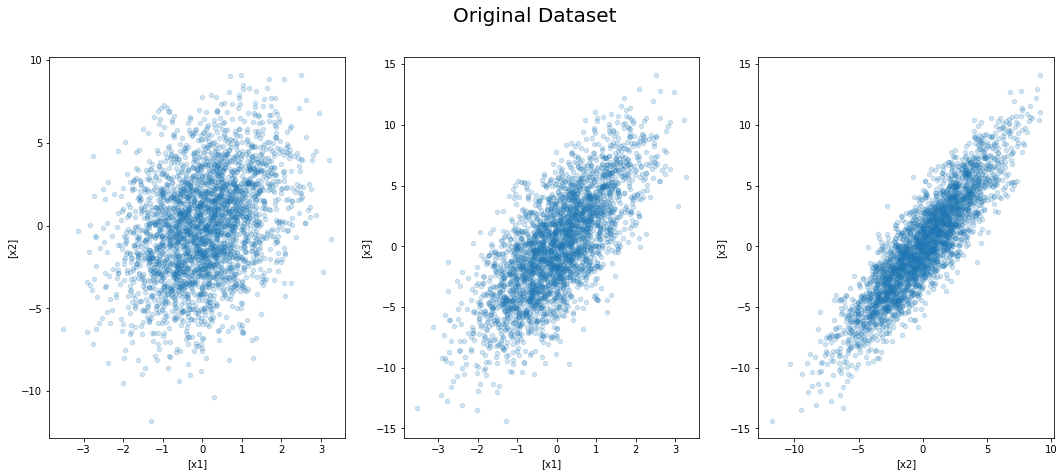

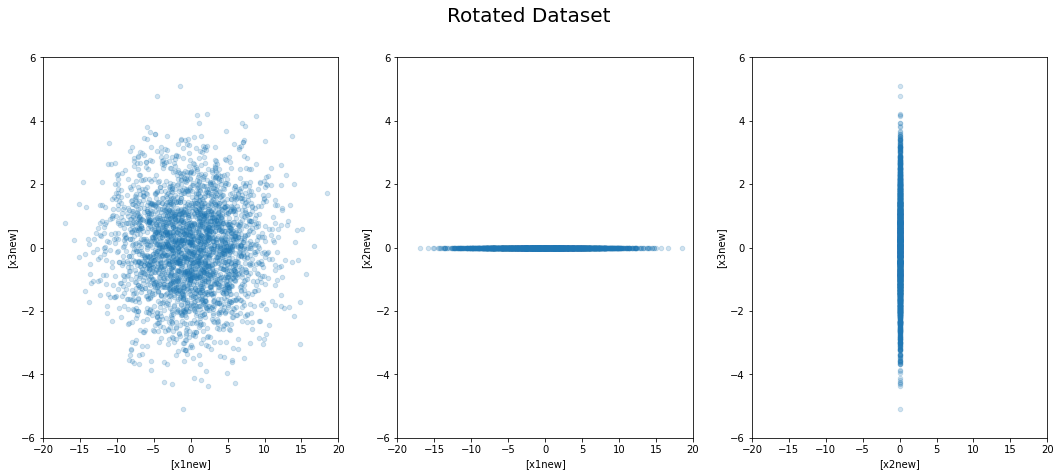

In [4]:
fig,axes = plt.subplots(nrows=1, ncols=3, figsize=(18, 7))
dataset.plot.scatter(['x1'], ['x2'], ax = axes[0], alpha = 0.2)
dataset.plot.scatter(['x1'], ['x3'], ax = axes[1], alpha = 0.2)
dataset.plot.scatter(['x2'], ['x3'], ax = axes[2], alpha = 0.2)
fig.suptitle('Original Dataset', fontsize = 20)


fig1,axes1 = plt.subplots(nrows=1, ncols=3, figsize=(18, 7))

dataset_rotated.plot.scatter(['x1new'], ['x3new'], ax = axes1[0], alpha = 0.2)
dataset_rotated.plot.scatter(['x1new'], ['x2new'], ax = axes1[1], alpha = 0.2)
dataset_rotated.plot.scatter(['x2new'], ['x3new'], ax = axes1[2], alpha = 0.2)
for i in range(3):
    axes1[i].set_xlim(-20,20)
    axes1[i].set_ylim(-6,6)

fig1.suptitle('Rotated Dataset', fontsize = 20)

plt.show()


2\. **PCA on a nD dataset**

Start from the dataset you have genereted in the previous exercise and add uncorrelated random noise. Such noise should be represented by other 10 uncorrelated variables normal distributed, with standar deviation much smaller (say, a factor 50) than those used to generate the $x_1$ and $x_2$.

Repeat the PCA procedure and compare the results with what you obtained before

In [5]:
#Copy the original dataset
noisy_dataset = dataset.copy()

#Append the columns with gaussian noise. The standard deviation of all noise columns is 1/50 = 0.02 multiplied
#by a random number between 0 and 1, drawn according to a uniform distribution.
for i in range(10):
    noisy_dataset['noise'+str(i)] = pd.Series(np.random.normal(0,0.02*np.random.uniform(0,1),N))
    
display(noisy_dataset)

,x1,x2,x3,noise0,noise1,noise2,noise3,noise4,noise5,noise6,noise7,noise8,noise9
0,-0.143766,0.005800,-0.281731,0.000009,-0.000840,-0.001444,-0.000113,-0.007711,0.000093,0.004488,-0.040327,-0.007433,-0.006672
1,1.343938,4.284756,6.972631,0.008560,-0.000631,0.011093,-0.015592,-0.011364,-0.003788,0.000199,-0.015468,-0.017880,-0.034883
2,-0.163083,-5.273278,-5.599444,-0.004239,0.001770,0.002266,-0.010786,-0.015193,0.003251,0.001556,-0.007849,0.014793,-0.006595
3,-1.315387,-3.362343,-5.993117,0.003544,0.001513,-0.000671,0.029805,-0.007508,0.001480,0.001793,0.019825,-0.022246,0.002368
4,0.000695,-2.073062,-2.071672,0.002243,0.011459,0.000533,0.001166,-0.025470,-0.000394,0.001766,0.000761,-0.011868,0.024624
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2995,-0.945890,-7.038842,-8.930622,-0.001112,0.002505,-0.008357,-0.003232,-0.006895,-0.002022,0.001736,-0.008042,-0.003355,-0.024418
2996,-1.170161,-0.568526,-2.908849,-0.007393,0.010351,-0.007859,-0.007250,0.019237,-0.001439,0.000524,0.016755,0.009405,0.021014
2997,-2.521916,2.215727,-2.828105,-0.005131,0.002519,-0.001257,-0.010189,0.001146,0.003970,-0.000535,0.016184,0.011854,0.002668
2998,-1.124674,-2.210455,-4.459804,-0.009377,-0.025651,0.006293,0.018004,0.006403,0.004077,0.001272,-0.002946,-0.003753,-0.003134


In [6]:
# PCA procedure
cov = np.cov(noisy_dataset.T)
l, V = la.eig(cov)

var = []
for i in range(len(l)):
    var.append(np.real_if_close(l[i]/l.sum()))

print('The percentage of variance of the dataset attributable to each column is respectively: ')
for i in range(len(var)):
    print(np.round(var[i]*100, 6),'%')
    
    
print('\n It\'s evident that the addition of random noise has not changed the principal components, nor their contribution to the overall variance of the data.')
print('Now we change basis.')
rotated_data = np.dot(V.T, noisy_dataset.T)
dataset_rotated = pd.DataFrame(rotated_data.T)
display(dataset_rotated)

print('From here we proceed as usual, we drop the unimportant columns.')
dataset_reduced = dataset_rotated.drop(dataset_rotated.columns[[i for i in range (2,13)]], axis = 1)

display(dataset_reduced)

The percentage of variance of the dataset attributable to each column is respectively: 
93.093977 %
6.901896 %
0.001029 %
0.000793 %
0.000639 %
0.000509 %
0.000431 %
0.000409 %
-0.0 %
0.000134 %
0.000106 %
6.2e-05 %
1.5e-05 %

 It's evident that the addition of random noise has not changed the principal components, nor their contribution to the overall variance of the data.
Now we change basis.


,0,1,2,3,4,5,6,7,8,9,10,11,12
0,-0.243355,-0.202116,-0.039583,0.006451,0.011285,-0.003944,0.003538,-0.005136,4.163336e-17,-0.000999,-0.000086,-0.000218,0.004387
1,8.272393,0.591946,-0.016652,0.003304,0.015582,-0.035123,0.019829,-0.002402,-2.664535e-15,0.011256,0.007377,0.003955,0.000171
2,-7.574061,1.349611,-0.007807,-0.002190,0.013603,-0.006556,-0.006483,0.018266,3.108624e-15,0.001759,-0.003601,-0.003446,0.001503
3,-6.947483,-0.827983,0.020766,-0.003392,0.008268,0.003840,-0.003551,-0.035667,2.220446e-15,-0.001059,0.003715,-0.000986,0.001677
4,-2.864247,0.620891,0.002250,-0.012538,0.025539,0.024923,0.007399,-0.005495,1.221245e-15,0.000585,0.003029,0.000822,0.001914
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2995,-11.383211,0.786471,-0.009577,-0.001287,0.007637,-0.023737,0.001519,-0.000991,3.996803e-15,-0.008850,-0.000598,0.002015,0.001756
2996,-2.831843,-1.461023,0.014796,-0.011822,-0.021724,0.018578,0.002132,0.012006,6.661338e-16,-0.007937,-0.006880,0.000824,0.000697
2997,-1.346869,-4.177753,0.015271,-0.003695,-0.002860,-0.000062,-0.000622,0.016456,-5.897489e-16,-0.001848,-0.004511,-0.004806,-0.000581
2998,-5.021844,-0.906607,0.000672,0.026489,-0.004902,-0.001248,-0.009691,-0.015435,1.588412e-15,0.005731,-0.009604,-0.004771,0.000924


From here we proceed as usual, we drop the unimportant columns.


,0,1
0,-0.243355,-0.202116
1,8.272393,0.591946
2,-7.574061,1.349611
3,-6.947483,-0.827983
4,-2.864247,0.620891
...,...,...
2995,-11.383211,0.786471
2996,-2.831843,-1.461023
2997,-1.346869,-4.177753
2998,-5.021844,-0.906607


3 \. **Looking at an oscillating spring** (optional)

Imagine you have $n$ cameras looking at a spring oscillating along the $x$ axis. Each  camera record the motion of the spring looking at it along a given direction defined by the pair $(\theta_i, \phi_i)$, the angles in spherical coordinates. 

Start from the simulation of the records (say ${\cal O}(1000)$) of the spring's motion along the x axis, assuming a little random noise affects the measurements along the $y$. Rotate such dataset to emulate the records of each camera.

Perform a Principal Component Analysis on the thus obtained dataset, aiming at finding the only one coordinate that really matters.

**Not entirely convinced, but I gave it a try**

,x,y,z
0,1.000000,0.002859,0.0
1,0.999921,-0.002585,0.0
2,0.999684,0.004094,0.0
3,0.999288,0.003617,0.0
4,0.998734,-0.001444,0.0
...,...,...,...
995,0.998734,-0.001145,0.0
996,0.999288,-0.001800,0.0
997,0.999684,0.001655,0.0
998,0.999921,-0.000627,0.0


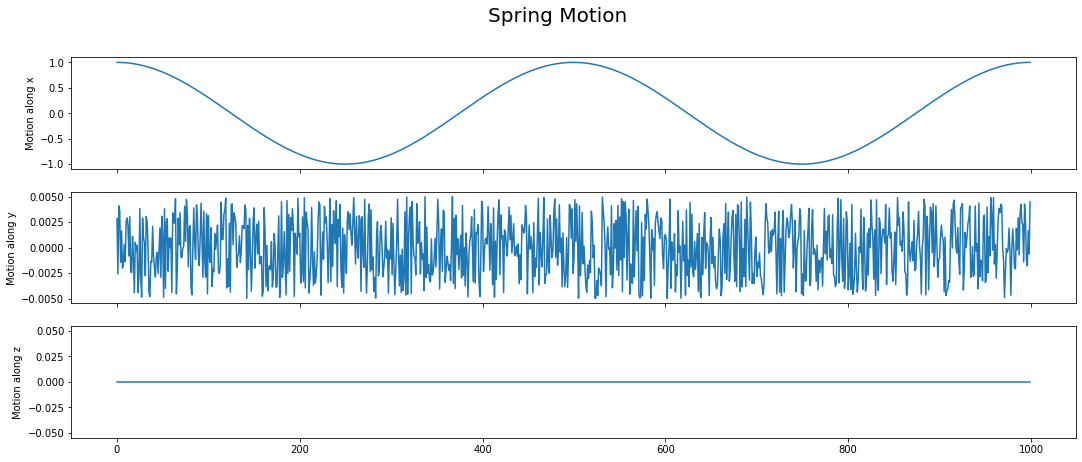

In [7]:
from IPython.display import display

N = 1000
columns = ['x','y', 'z']
index = np.arange(N)
spring_dataset = pd.DataFrame(index = index, columns = columns)
spring_dataset['x'] = pd.Series(np.cos(np.linspace(0,4*np.pi,N)))
spring_dataset['y'] = pd.Series(np.random.uniform(-0.005,0.005,N))
spring_dataset['z'] = pd.Series(np.zeros(N))
display(spring_dataset)

fig,axes = plt.subplots(nrows=3, ncols=1, figsize=(18, 7), sharex = True)
axes[0].plot(index, spring_dataset['x'])
axes[0].set_ylabel('Motion along x')
axes[1].plot(index, spring_dataset['y'])
axes[1].set_ylabel('Motion along y')
axes[2].plot(index, spring_dataset['z'])
axes[2].set_ylabel('Motion along z')
fig.suptitle('Spring Motion', fontsize = 20)

plt.show()

I will name the angles as follows: 


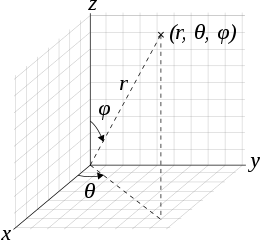

In [8]:
from scipy.spatial.transform import Rotation
from IPython import display
print('I will name the angles as follows: ')
display.Image('https://upload.wikimedia.org/wikipedia/commons/thumb/d/dc/3D_Spherical_2.svg/260px-3D_Spherical_2.svg.png')

[[ 0. -1.  0.]
 [ 1.  0.  0.]
 [ 0.  0.  1.]]
[2, -4, 0] [4. 2. 0.]


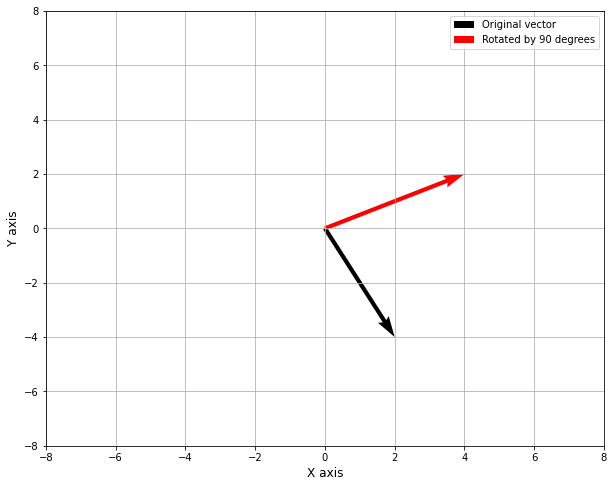

In [9]:
#Check how the library works.

u = [2,-4,0] # Vector in XY plane
fig, axes=  plt.subplots(nrows=1, ncols=1, figsize=(10, 8))
axes.set_xlim(-8,8)
axes.set_ylim(-8,8)
axes.quiver(0, 0, u[0], u[1], angles='xy', scale_units='xy', scale=1, label = 'Original vector')
axes.grid()
axes.set_xlabel('X axis', fontsize = 12)
axes.set_ylabel('Y axis', fontsize = 12)

phi_theta = [0,90] #Rotation angles, supposedly leaving the vector in the XY plane
phi = Rotation.from_euler('x', phi_theta[0], degrees = True) #Kind of like above picture.
theta = Rotation.from_euler('z', phi_theta[1], degrees = True) #Kind of like above picture.
ROT = phi*theta #Create rotation matrix (type is 'rotation object' still)
rot_matrix = ROT.as_matrix() #Convert to matrix
print(rot_matrix)
u_rotated = np.dot(rot_matrix,u) #Anticlockwise rotation of angle theta = 90 (XY plane)



axes.quiver(0, 0, u_rotated[0], u_rotated[1], angles='xy', scale_units='xy', scale=1, color = 'red', label = 'Rotated by 90 degrees')
plt.legend()
print(u, u_rotated)

[[ 1.  0.  0.]
 [ 0.  0. -1.]
 [ 0.  1.  0.]]
[0, 2, -4] [0. 4. 2.]


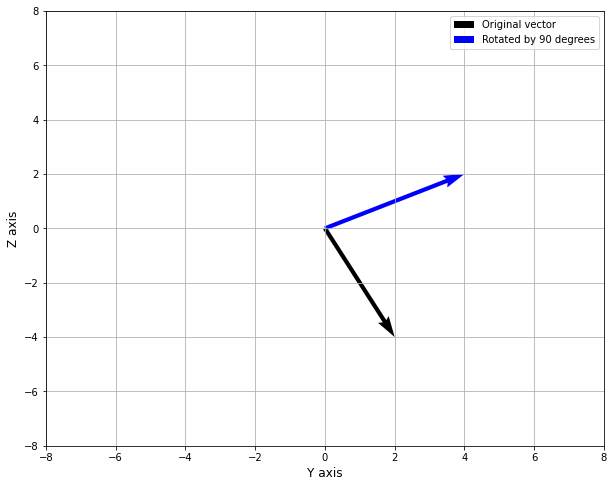

In [10]:
#Check in YZ plane

u = [0,2,-4] # Vector in YZ plane
fig, axes=  plt.subplots(nrows=1, ncols=1, figsize=(10, 8))
axes.set_xlim(-8,8)
axes.set_ylim(-8,8)
axes.quiver(0, 0, u[1], u[2], angles='xy', scale_units='xy', scale=1, label = 'Original vector')
axes.grid()
axes.set_xlabel('Y axis', fontsize = 12)
axes.set_ylabel('Z axis', fontsize = 12)

phi_theta = [90,0] #Rotation angles, supposedly leaving the vector in the YZ plane
phi = Rotation.from_euler('x', phi_theta[0], degrees = True) #Kind of like above picture.
theta = Rotation.from_euler('z', phi_theta[1], degrees = True) #Kind of like above picture.
ROT = phi*theta #Create rotation matrix (type is 'rotation object' still)
rot_matrix = ROT.as_matrix() #Convert to matrix
print(rot_matrix)
u_rotated = np.dot(rot_matrix, u) #Anticlockwise rotation of angle phi = 90 (YZ plane)



axes.quiver(0, 0, u_rotated[1], u_rotated[2], angles='xy', scale_units='xy', scale=1, color = 'blue', label = 'Rotated by 90 degrees')
plt.legend()
print(u, u_rotated)

[[ 0. -1.  0.]
 [ 1.  0.  0.]
 [-0. -0.  1.]]
[2, 2, 2] [-2.  2.  2.]


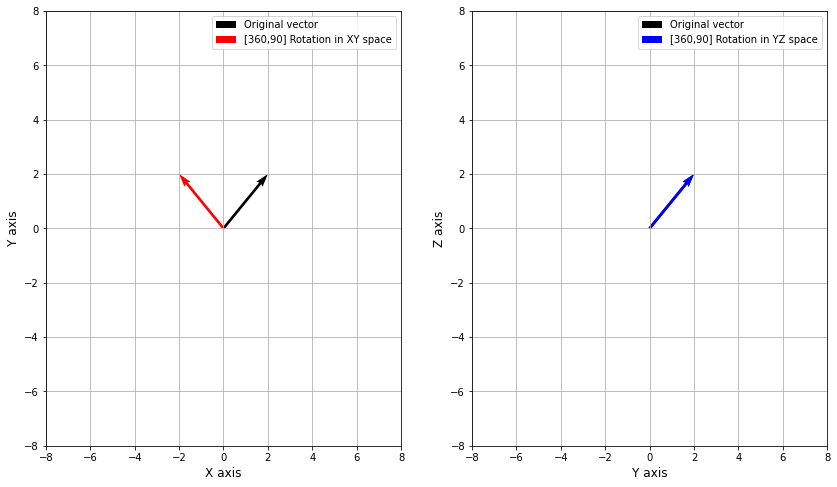

In [11]:
#Final check. I will rotate by [90][360]
u = [2,2,2] # Initial vector
fig, axes=  plt.subplots(nrows=1, ncols=2, figsize=(14, 8))
axes[0].set_xlim(-8,8)
axes[0].set_ylim(-8,8)
axes[0].quiver(0, 0, u[0], u[1], angles='xy', scale_units='xy', scale=1, label = 'Original vector')
axes[0].grid()
axes[0].set_xlabel('X axis', fontsize = 12)
axes[0].set_ylabel('Y axis', fontsize = 12)

phi_theta = [360,90] #Rotation angles
phi = Rotation.from_euler('x', phi_theta[0], degrees = True) #Kind of like above picture. (clockwise rotation)
theta = Rotation.from_euler('z', phi_theta[1], degrees = True) #Kind of like above picture. (clockwise rotation)
ROT = phi*theta #Create rotation matrix (type is 'rotation object' still)
rot_matrix = ROT.as_matrix() #Convert to matrix
print(rot_matrix)
u_rotated = np.dot(rot_matrix,u)
axes[0].quiver(0, 0, u_rotated[0], u_rotated[1], angles='xy', scale_units='xy', scale=1, color = 'red', label = '[360,90] Rotation in XY space')
axes[0].legend()

axes[1].set_xlim(-8,8)
axes[1].set_ylim(-8,8)
axes[1].quiver(0, 0, u[1], u[2], angles='xy', scale_units='xy', scale=1, label = 'Original vector')
axes[1].grid()
axes[1].set_xlabel('Y axis', fontsize = 12)
axes[1].set_ylabel('Z axis', fontsize = 12)
axes[1].quiver(0, 0, u_rotated[1], u_rotated[2], angles='xy', scale_units='xy', scale=1, color = 'blue', label = '[360,90] Rotation in YZ space')
axes[1].legend()

print(u, u_rotated)

In [12]:
#Now i create a bunch of 'cameras' by creating various angles
from IPython.display import display

phi_theta = []
for i in range(13):
    phi_theta.append([i*15, i*30])

spring_dataset1 = spring_dataset.copy()
for angles in phi_theta:
    phi = Rotation.from_euler('x', angles[0], degrees = True)
    theta = Rotation.from_euler('z', angles[1], degrees = True)
    ROT = theta*phi
    camera_measurement = np.dot(spring_dataset, ROT.as_matrix()) #This way rotation is done clockwise
    spring_dataset1['x('+str(angles[0])+','+str(angles[1])+')'] = camera_measurement[:,0]
    spring_dataset1['y('+str(angles[0])+','+str(angles[1])+')'] = camera_measurement[:,1]
    spring_dataset1['z('+str(angles[0])+','+str(angles[1])+')'] = camera_measurement[:,2]

display(spring_dataset1)

,x,y,z,"x(0,0)","y(0,0)","z(0,0)","x(15,30)","y(15,30)","z(15,30)","x(30,60)",...,"z(135,270)","x(150,300)","y(150,300)","z(150,300)","x(165,330)","y(165,330)","z(165,330)","x(180,360)","y(180,360)","z(180,360)"
0,1.000000,0.002859,0.0,1.000000,0.002859,0.0,0.867455,-0.480572,0.128769,0.502476,...,-0.707107,0.497524,-0.751238,-0.433727,0.864596,-0.485354,-0.130050,1.000000,-0.002859,-3.500845e-19
1,0.999921,-0.002585,0.0,0.999921,-0.002585,0.0,0.864664,-0.485087,0.129979,0.497721,...,-0.707051,0.502200,-0.748821,-0.432332,0.867250,-0.480762,-0.128820,0.999921,0.002585,3.166273e-19
2,0.999684,0.004094,0.0,0.999684,0.004094,0.0,0.867798,-0.479385,0.128451,0.503387,...,-0.706883,0.496296,-0.751536,-0.433899,0.863704,-0.486235,-0.130286,0.999684,-0.004094,-5.013941e-19
3,0.999288,0.003617,0.0,0.999288,0.003617,0.0,0.867217,-0.479593,0.128507,0.502776,...,-0.706603,0.496512,-0.751032,-0.433609,0.863600,-0.485645,-0.130128,0.999288,-0.003617,-4.429397e-19
4,0.998734,-0.001444,0.0,0.998734,-0.001444,0.0,0.864208,-0.483559,0.129569,0.498117,...,-0.706212,0.500617,-0.748426,-0.432104,0.865651,-0.481144,-0.128922,0.998734,0.001444,1.767851e-19
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,0.998734,-0.001145,0.0,0.998734,-0.001145,0.0,0.864357,-0.483310,0.129502,0.498375,...,-0.706212,0.500359,-0.748555,-0.432178,0.865502,-0.481393,-0.128989,0.998734,0.001145,1.402773e-19
996,0.999288,-0.001800,0.0,0.999288,-0.001800,0.0,0.864509,-0.484125,0.129721,0.498085,...,-0.706603,0.501203,-0.748686,-0.432254,0.866309,-0.481113,-0.128914,0.999288,0.001800,2.204771e-19
997,0.999684,0.001655,0.0,0.999684,0.001655,0.0,0.866579,-0.481426,0.128998,0.501275,...,-0.706883,0.498408,-0.750479,-0.433289,0.864924,-0.484195,-0.129740,0.999684,-0.001655,-2.026819e-19
998,0.999921,-0.000627,0.0,0.999921,-0.000627,0.0,0.865644,-0.483449,0.129540,0.499418,...,-0.707051,0.500503,-0.749669,-0.432822,0.866270,-0.482401,-0.129259,0.999921,0.000627,7.673206e-20


The percentage of variance of the dataset attributable to each column is respectively: 
99.998415 %
0.001585 %
0.0 %
-0.0 %
0.0 %
-0.0 %
-0.0 %
0.0 %
0.0 %
0.0 %
0.0 %
-0.0 %
-0.0 %
-0.0 %
-0.0 %
-0.0 %
-0.0 %
-0.0 %
0.0 %
0.0 %
-0.0 %
-0.0 %
-0.0 %
0.0 %
0.0 %
-0.0 %
0.0 %
-0.0 %
0.0 %
0.0 %
-0.0 %
0.0 %
0.0 %
0.0 %
-0.0 %
0.0 %
From here we proceed as usual, we drop the unimportant columns. We get a single column which contains most of the variability of the dataset.
At this point we can analyze the data and then we can rotate back to the original frame.


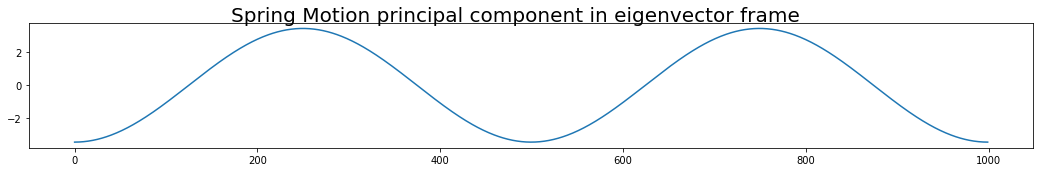

In [13]:
#Now i will drop the first 6 columns. To intuitively "remove" the correct frame from the problem

spring_dataset_red = spring_dataset1.drop(spring_dataset1.columns[[i for i in range (6)]], axis = 1)

#Perform the PCA
cov = np.cov(spring_dataset_red.T)
l, V = la.eig(cov)

var = []
for i in range(len(l)):
    var.append(np.real_if_close(l[i]/l.sum()))

print('The percentage of variance of the dataset attributable to each column is respectively: ')
for i in range(len(var)):
    print(np.round(var[i]*100, 6),'%')

change_of_basis_spring = np.dot(V.T, spring_dataset_red.T)
new_basis_spring = pd.DataFrame(change_of_basis_spring.T)

print('From here we proceed as usual, we drop the unimportant columns. We get a single column which contains most of the variability of the dataset.')
new_basis_spring_reduced = new_basis_spring.drop(new_basis_spring.columns[[i for i in range (1,36)]], axis = 1)

new_basis_spring_reduced
fig,axes = plt.subplots(nrows=1, ncols=1, figsize=(18, 2.3))
axes.plot(index, np.real_if_close(new_basis_spring_reduced[0]))
fig.suptitle('Spring Motion principal component in eigenvector frame', fontsize = 20)

print('At this point we can analyze the data and then we can rotate back to the original frame.')

4\. **PCA on the MAGIC dataset** (optional)

Perform a PCA on the magic04.data dataset

In [14]:
# get the dataset and its description on the proper data directory
#!wget https://archive.ics.uci.edu/ml/machine-learning-databases/magic/magic04.data -P ~/data/
#!wget https://archive.ics.uci.edu/ml/machine-learning-databases/magic/magic04.names -P ~/data/ 

In [15]:
from IPython.display import display
columns = ['flenght', 'fWidth', 'fSize', 'fConc', 'fConc1', 'fAsym', 'fM3Long', 'fM3Trans', 'fAlpha', 'fDist', 'category']
magic_dataset = pd.read_csv('magic04.data', nrows = 2000, names = columns)
#mask = (dataset['category'] == 'h')
#print(dataset[mask]) 
# We can preemptely drop the category column since it's only ever equal to g
magic_dataset.drop(columns = 'category', inplace = True)
display(magic_dataset)
cov = np.cov(magic_dataset.T)

l,V = la.eig(cov)
var = []
for i in range(len(l)):
    var.append(np.real_if_close(l[i]/l.sum()))

for i in range(len(var)):
    print('Eigenvector', V[:,i], 'with eigenvalue', np.round(np.real_if_close(l[i]),5), 'accounts for', np.round(var[i]*100,5), '% of the dataset variance.\n')

,flenght,fWidth,fSize,fConc,fConc1,fAsym,fM3Long,fM3Trans,fAlpha,fDist
0,28.7967,16.0021,2.6449,0.3918,0.1982,27.7004,22.0110,-8.2027,40.0920,81.8828
1,31.6036,11.7235,2.5185,0.5303,0.3773,26.2722,23.8238,-9.9574,6.3609,205.2610
2,162.0520,136.0310,4.0612,0.0374,0.0187,116.7410,-64.8580,-45.2160,76.9600,256.7880
3,23.8172,9.5728,2.3385,0.6147,0.3922,27.2107,-6.4633,-7.1513,10.4490,116.7370
4,75.1362,30.9205,3.1611,0.3168,0.1832,-5.5277,28.5525,21.8393,4.6480,356.4620
...,...,...,...,...,...,...,...,...,...,...
1995,58.8813,27.5643,3.3251,0.1272,0.0636,23.5287,-29.2176,-6.3803,6.4020,150.4130
1996,22.1436,17.8129,2.5270,0.4309,0.2719,16.2603,17.3968,-13.3663,14.4690,155.1240
1997,55.6748,22.1855,2.3683,0.5139,0.2762,-44.8512,-24.9746,10.1152,4.6566,337.9010
1998,16.5737,11.4093,2.2833,0.5833,0.3255,2.8231,-7.2764,5.7233,45.9059,150.2680


Eigenvector [-0.24054 -0.05758 -0.00344  0.00106  0.00059  0.12525 -0.17847 -0.00108
  0.13567 -0.93427] with eigenvalue 5497.96016 accounts for 61.16884 % of the dataset variance.

Eigenvector [-0.11412 -0.04838 -0.00335  0.00108  0.00062 -0.88641 -0.4388   0.00522
  0.07908  0.00884] with eigenvalue 1696.62846 accounts for 18.87624 % of the dataset variance.

Eigenvector [ 0.33557  0.08252  0.00542 -0.00194 -0.00113 -0.43752  0.7662  -0.00871
 -0.08253 -0.3085 ] with eigenvalue 967.51984 accounts for 10.76437 % of the dataset variance.

Eigenvector [ 0.3314   0.09063  0.00651 -0.0034  -0.00196  0.02145 -0.30065 -0.01534
 -0.87518 -0.1577 ] with eigenvalue 369.41645 accounts for 4.11003 % of the dataset variance.

Eigenvector [-0.77521 -0.26127 -0.00891  0.0032   0.0018  -0.07741  0.30986  0.15139
 -0.44631  0.08117] with eigenvalue 240.2668 accounts for 2.67314 % of the dataset variance.

Eigenvector [-0.13179 -0.02762 -0.00158  0.00072  0.00046 -0.01351  0.0435  -0.98818
 -0.05413  

In [16]:
rotated_data = np.dot(V.T, magic_dataset.T)
dataset_rotated = pd.DataFrame(rotated_data.T)
display(dataset_rotated)

print('From here we can choose a threshold for the variance and drop an appropriate number of columns.')

,0,1,2,3,4,5,6,7,8,9
0,-79.368308,-34.429474,-12.755039,-42.889142,-34.338805,3.817669,-6.181440,1.833493,-1.243434,0.121758
1,-200.142171,-35.657374,-45.416266,-32.832881,-9.919303,9.544223,-3.060736,1.647868,-1.393740,0.048236
2,-250.049295,-91.987497,-120.318696,-19.092507,-210.683418,15.825722,-77.820339,-0.742649,-1.488628,0.120454
3,-109.364589,-22.650598,-44.876986,-16.144528,-21.362004,4.641233,-2.035513,1.611166,-1.438693,0.079947
4,-358.078098,-14.076378,-58.464182,-41.597442,-26.910283,-24.574109,-11.065478,1.543791,-1.342757,0.106953
...,...,...,...,...,...,...,...,...,...,...
1995,-147.251540,-14.296292,-57.504279,2.096638,-55.364637,-1.328447,-8.922446,2.037784,-1.259555,0.109199
1996,-150.379125,-22.997726,-33.804232,-32.835167,-13.598314,12.465312,-11.164236,1.605453,-1.273584,0.079688
1997,-330.908418,46.689850,-83.700993,-30.496042,-26.360911,-12.327383,-8.252467,1.210714,-1.281820,0.120682
1998,-137.168088,3.228916,-50.491818,-55.173923,-25.744310,-8.171764,-6.222457,1.712642,-1.306588,0.112298


From here we can choose a threshold for the variance and drop an appropriate number of columns.
